#Download and extract data

I am running the code using the link to google drive that was sent to me. If you want to run this code again it might be necessary to change the path to the dataset below. 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip "drive/MyDrive/Data Science challenge Flavio/ DS_Assignment_Data.zip" -d "/data/"

Archive:  drive/MyDrive/Data Science challenge Flavio/ DS_Assignment_Data.zip
  inflating: /data/2018_08.csv       
  inflating: /data/__MACOSX/._2018_08.csv  
  inflating: /data/2018_09.csv       
  inflating: /data/__MACOSX/._2018_09.csv  
  inflating: /data/2018_10.csv       
  inflating: /data/__MACOSX/._2018_10.csv  
  inflating: /data/2018_11.csv       
  inflating: /data/__MACOSX/._2018_11.csv  
  inflating: /data/2018_07.csv       
  inflating: /data/__MACOSX/._2018_07.csv  
  inflating: /data/2019_05.csv       
  inflating: /data/__MACOSX/._2019_05.csv  
  inflating: /data/2019_04.csv       
  inflating: /data/__MACOSX/._2019_04.csv  
  inflating: /data/2019_03.csv       
  inflating: /data/__MACOSX/._2019_03.csv  
  inflating: /data/2019_02.csv       
  inflating: /data/__MACOSX/._2019_02.csv  
  inflating: /data/2019_01.csv       
  inflating: /data/__MACOSX/._2019_01.csv  
  inflating: /data/2018_12.csv       
  inflating: /data/__MACOSX/._2018_12.csv  
  inflating: /data/2

# Libraries

In [ ]:
import os
import pandas as pd
import seaborn as sns
import numpy as np
import math

In [ ]:
from __future__ import print_function
import json
import time
import datetime

try:
    from urllib.request import urlopen
except ImportError:
    from urllib2 import urlopen

In [ ]:
import warnings
warnings.filterwarnings("ignore")

Library necessary for training model. 

In [ ]:
!pip install h2o

In [ ]:
import h2o
from h2o.estimators import H2OGradientBoostingEstimator, H2ODeepLearningEstimator

# Data Preparation

## Build Original Datasets

Here I am concatenating all csv files provided in a single train and test set. 

In [ ]:
train_files = ['2018_07.csv','2018_08.csv', '2018_09.csv', '2018_10.csv', '2018_11.csv', '2018_12.csv', '2019_01.csv', '2019_02.csv', '2019_03.csv', '2019_04.csv', '2019_05.csv', '2019_06.csv' ]
test_files = ['2019_07.csv','2019_08.csv']

In [ ]:
train_data = pd.DataFrame()
for train_file in train_files:
  train_data_month = pd.read_csv('/data/' + train_file)
  train_data = pd.concat([train_data, train_data_month])
train_data = train_data.loc[:,~train_data.columns.str.match("Unnamed")]

In [ ]:
test_data = pd.DataFrame()
for test_file in test_files:
  test_data_month = pd.read_csv('/data/' + test_file)
  test_data = pd.concat([test_data, test_data_month])
test_data = test_data.loc[:,~test_data.columns.str.match("Unnamed")]

Convert variables to categorical and datetime type

In [ ]:
train_data = train_data.astype({"OP_UNIQUE_CARRIER":'category', "ORIGIN":'category', "DEST":'category'})
test_data = test_data.astype({"OP_UNIQUE_CARRIER":'category', "ORIGIN":'category', "DEST":'category'})

In [ ]:
train_data['FL_DATE'] = pd.to_datetime(train_data['FL_DATE'])
test_data['FL_DATE'] = pd.to_datetime(test_data['FL_DATE'])

In [ ]:
del train_data_month

In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7306180 entries, 0 to 636690
Data columns (total 22 columns):
 #   Column               Dtype         
---  ------               -----         
 0   FL_DATE              datetime64[ns]
 1   OP_UNIQUE_CARRIER    category      
 2   OP_CARRIER_FL_NUM    int64         
 3   ORIGIN               category      
 4   DEST                 category      
 5   CRS_DEP_TIME         int64         
 6   DEP_TIME             float64       
 7   DEP_DELAY            float64       
 8   CRS_ARR_TIME         int64         
 9   ARR_TIME             float64       
 10  ARR_DELAY            float64       
 11  CANCELLED            float64       
 12  CANCELLATION_CODE    object        
 13  CRS_ELAPSED_TIME     float64       
 14  ACTUAL_ELAPSED_TIME  float64       
 15  AIR_TIME             float64       
 16  DISTANCE             float64       
 17  CARRIER_DELAY        float64       
 18  WEATHER_DELAY        float64       
 19  NAS_DELAY            f

##Filter Carriers

Since it was told in the notes that I should use a subset of the 8 most frequent carries, i am filtering them here. 

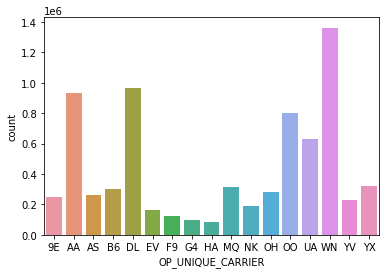

In [ ]:
ax = sns.countplot(x="OP_UNIQUE_CARRIER", data=train_data)

In [ ]:
common_carriers = train_data['OP_UNIQUE_CARRIER'].value_counts()[0:8].index

In [ ]:
train_data = train_data[train_data['OP_UNIQUE_CARRIER'].isin(common_carriers)]

In [ ]:
test_data = test_data[test_data['OP_UNIQUE_CARRIER'].isin(common_carriers)]

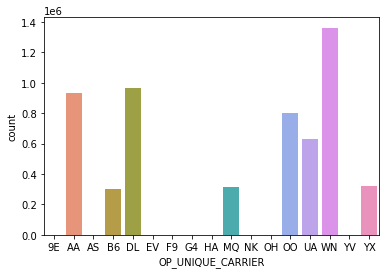

In [ ]:
ax = sns.countplot(x="OP_UNIQUE_CARRIER", data=train_data)

##Analysis of Cancelled Flights

In [ ]:
train_data['CANCELLED'].value_counts()

0.0    5528595
1.0      99362
Name: CANCELLED, dtype: int64

In [ ]:
train_data[['CANCELLED', 'CANCELLATION_CODE']].value_counts()

CANCELLED  CANCELLATION_CODE
1.0        B                    52606
           A                    28303
           C                    18419
           D                       34
dtype: int64

In [ ]:
train_data[train_data['CANCELLED'] > 0].groupby(['CANCELLATION_CODE']).mean()

,OP_CARRIER_FL_NUM,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,CANCELLED,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY
CANCELLATION_CODE,,,,,,,,,,,,,,,,,
A,2130.276402,1265.289545,1359.472189,73.22619,1423.792213,NaN,NaN,1.0,136.498640,NaN,NaN,769.738332,NaN,NaN,NaN,NaN,NaN
B,2770.446261,1409.959948,1582.374641,59.77765,1545.711136,NaN,NaN,1.0,127.648215,NaN,NaN,668.536726,NaN,NaN,NaN,NaN,NaN
C,3360.593952,1528.650035,1543.148459,60.21037,1675.657148,NaN,NaN,1.0,117.369890,NaN,NaN,550.261958,NaN,NaN,NaN,NaN,NaN
D,1384.235294,1343.352941,1438.500000,205.00000,1563.794118,NaN,NaN,1.0,159.264706,NaN,NaN,997.294118,NaN,NaN,NaN,NaN,NaN


In [ ]:
train_data[train_data['CANCELLED'] > 0].sample(10)

,FL_DATE,OP_UNIQUE_CARRIER,OP_CARRIER_FL_NUM,ORIGIN,DEST,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,CRS_ARR_TIME,ARR_TIME,...,CANCELLATION_CODE,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY
468310,2019-06-23,AA,1821,DFW,LAX,2131,NaN,NaN,2243,NaN,...,B,192.0,NaN,NaN,1235.0,NaN,NaN,NaN,NaN,NaN
247505,2019-03-13,MQ,4214,DFW,FSM,1030,NaN,NaN,1133,NaN,...,B,63.0,NaN,NaN,227.0,NaN,NaN,NaN,NaN,NaN
129679,2019-05-07,WN,1124,BUR,OAK,900,NaN,NaN,1015,NaN,...,A,75.0,NaN,NaN,325.0,NaN,NaN,NaN,NaN,NaN
222193,2018-10-11,AA,2592,LAX,RDU,715,NaN,NaN,1503,NaN,...,B,288.0,NaN,NaN,2239.0,NaN,NaN,NaN,NaN,NaN
263205,2018-12-14,YX,4693,CLT,HHH,1730,NaN,NaN,1836,NaN,...,B,66.0,NaN,NaN,207.0,NaN,NaN,NaN,NaN,NaN
486287,2019-06-23,AA,1387,ORD,DEN,2036,2214.0,98.0,2217,NaN,...,A,161.0,NaN,NaN,888.0,NaN,NaN,NaN,NaN,NaN
24707,2019-03-02,AA,1725,BOS,PHL,1009,NaN,NaN,1145,NaN,...,B,96.0,NaN,NaN,280.0,NaN,NaN,NaN,NaN,NaN
573375,2019-05-29,AA,2345,MKE,DFW,1645,NaN,NaN,1922,NaN,...,B,157.0,NaN,NaN,853.0,NaN,NaN,NaN,NaN,NaN
506571,2018-12-27,UA,1920,AUS,IAH,535,NaN,NaN,629,NaN,...,B,54.0,NaN,NaN,140.0,NaN,NaN,NaN,NaN,NaN
256546,2019-05-13,AA,1848,MCO,PHL,1732,NaN,NaN,2011,NaN,...,B,159.0,NaN,NaN,861.0,NaN,NaN,NaN,NaN,NaN


Apparently, cancelled flights are not 'delayed'. Some registries have values for DEP_TIME but I assume it to be noise. I decide to filter out cancelled flights for further analysis. 

In [ ]:
train_data = train_data[train_data['CANCELLED'] == 0]
test_data = test_data[test_data['CANCELLED'] == 0]

In [ ]:
train_data = train_data.drop(columns=['CANCELLED','CANCELLATION_CODE'])
test_data = test_data.drop(columns=['CANCELLED','CANCELLATION_CODE'])

In [ ]:
train_data.columns

Index(['FL_DATE', 'OP_UNIQUE_CARRIER', 'OP_CARRIER_FL_NUM', 'ORIGIN', 'DEST',
       'CRS_DEP_TIME', 'DEP_TIME', 'DEP_DELAY', 'CRS_ARR_TIME', 'ARR_TIME',
       'ARR_DELAY', 'CRS_ELAPSED_TIME', 'ACTUAL_ELAPSED_TIME', 'AIR_TIME',
       'DISTANCE', 'CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY',
       'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY'],
      dtype='object')

## Dealing with Date and Time of Departure/Arrival

In [ ]:
train_data['FL_DAYWEEK'] = train_data['FL_DATE'].dt.dayofweek
train_data['FL_MONTH'] = train_data['FL_DATE'].dt.month
train_data['FL_DEP_HOUR'] = (train_data['CRS_DEP_TIME']/100).apply(np.floor)
train_data['FL_DEP_HOUR'] = pd.to_numeric(train_data['FL_DEP_HOUR'], downcast='integer')
train_data['FL_ARR_HOUR'] = (train_data['CRS_ARR_TIME']/100).apply(np.floor)
train_data['FL_ARR_HOUR'] = pd.to_numeric(train_data['FL_ARR_HOUR'], downcast='integer')
test_data['FL_DAYWEEK'] = test_data['FL_DATE'].dt.dayofweek
test_data['FL_MONTH'] = test_data['FL_DATE'].dt.month
test_data['FL_DEP_HOUR'] = (test_data['CRS_DEP_TIME']/100).apply(np.floor)
test_data['FL_DEP_HOUR'] = pd.to_numeric(test_data['FL_DEP_HOUR'], downcast='integer')
test_data['FL_ARR_HOUR'] = (test_data['CRS_ARR_TIME']/100).apply(np.floor)
test_data['FL_ARR_HOUR'] = pd.to_numeric(test_data['FL_ARR_HOUR'], downcast='integer')

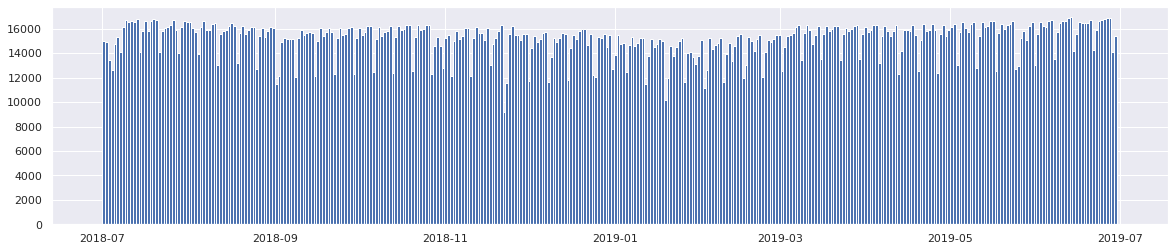

In [ ]:
sns.set(rc={'figure.figsize':(20,4)})
train_data['FL_DATE'].hist(bins=365)

Most flights happen on summer, but fairly distributed through the week. Less flights happen on saturday. 

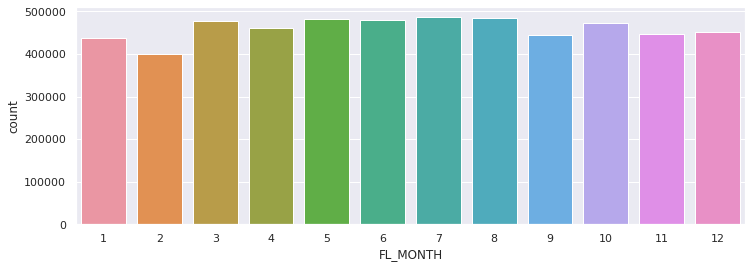

In [ ]:
sns.set(rc={'figure.figsize':(12,4)})
ax = sns.countplot(x="FL_MONTH", data=train_data)

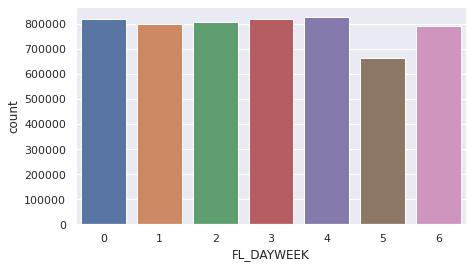

In [ ]:
sns.set(rc={'figure.figsize':(7,4)})
ax = sns.countplot(x="FL_DAYWEEK", data=train_data)

Unsurprisingly, most flights depart after 6h and arrival is correlated with departure with a small lag. 

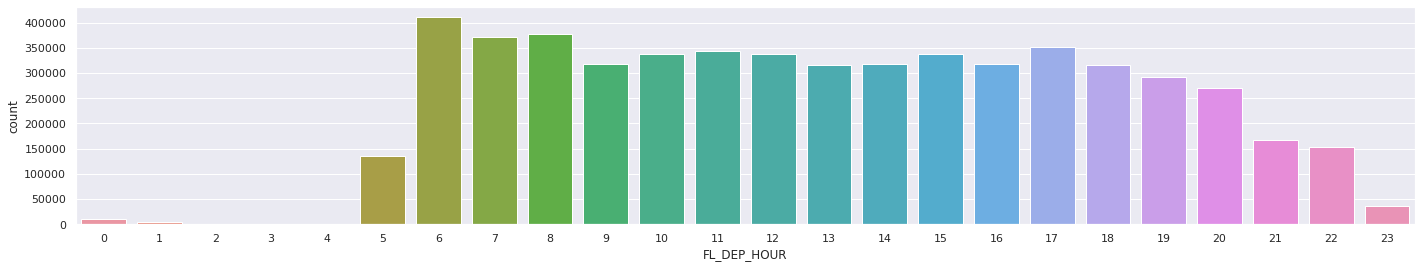

In [ ]:
sns.set(rc={'figure.figsize':(24,4)})
ax = sns.countplot(x="FL_DEP_HOUR", data=train_data)

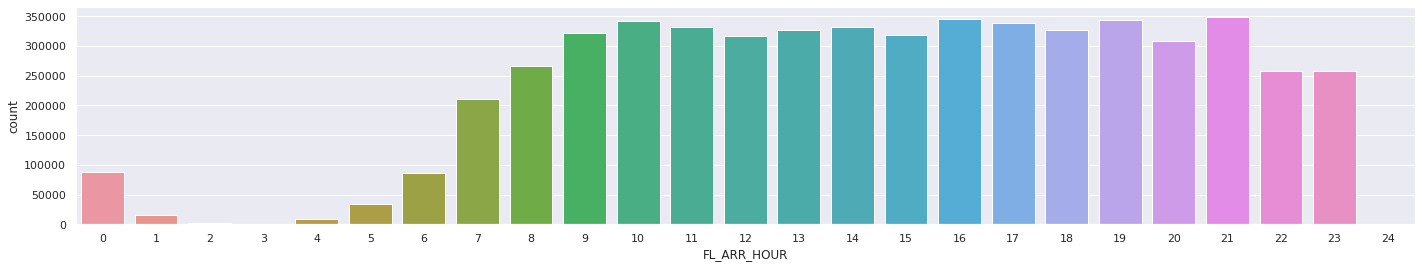

In [ ]:
sns.set(rc={'figure.figsize':(24,4)})
ax = sns.countplot(x="FL_ARR_HOUR", data=train_data)

Weekday, month and hour are circular numeric data (e.g. 23h and 1h are equally similar to 0h). Therefore they need to be transformed accordingly. 

In [ ]:
train_data['SIN_DEP_HOUR'] = train_data['FL_DEP_HOUR'].apply(lambda x: math.sin(2*math.pi*x/24))
train_data['COS_DEP_HOUR'] = train_data['FL_DEP_HOUR'].apply(lambda x: math.cos(2*math.pi*x/24))
train_data['SIN_ARR_HOUR'] = train_data['FL_ARR_HOUR'].apply(lambda x: math.sin(2*math.pi*x/24))
train_data['COS_ARR_HOUR'] = train_data['FL_ARR_HOUR'].apply(lambda x: math.cos(2*math.pi*x/24))
train_data['SIN_DAYWEEK'] = train_data['FL_DAYWEEK'].apply(lambda x: math.sin(2*math.pi*x/7))
train_data['COS_DAYWEEK'] = train_data['FL_DAYWEEK'].apply(lambda x: math.cos(2*math.pi*x/7))
train_data['SIN_MONTH'] = train_data['FL_MONTH'].apply(lambda x: math.sin(2*math.pi*x/12))
train_data['COS_MONTH'] = train_data['FL_MONTH'].apply(lambda x: math.cos(2*math.pi*x/12))

test_data['SIN_DEP_HOUR'] = test_data['FL_DEP_HOUR'].apply(lambda x: math.sin(2*math.pi*x/24))
test_data['COS_DEP_HOUR'] = test_data['FL_DEP_HOUR'].apply(lambda x: math.cos(2*math.pi*x/24))
test_data['SIN_ARR_HOUR'] = test_data['FL_ARR_HOUR'].apply(lambda x: math.sin(2*math.pi*x/24))
test_data['COS_ARR_HOUR'] = test_data['FL_ARR_HOUR'].apply(lambda x: math.cos(2*math.pi*x/24))
test_data['SIN_DAYWEEK'] = test_data['FL_DAYWEEK'].apply(lambda x: math.sin(2*math.pi*x/7))
test_data['COS_DAYWEEK'] = test_data['FL_DAYWEEK'].apply(lambda x: math.cos(2*math.pi*x/7))
test_data['SIN_MONTH'] = test_data['FL_MONTH'].apply(lambda x: math.sin(2*math.pi*x/12))
test_data['COS_MONTH'] = test_data['FL_MONTH'].apply(lambda x: math.cos(2*math.pi*x/12))

##Drop Columns

In [ ]:
drop_columns = ['OP_CARRIER_FL_NUM','CRS_DEP_TIME','CRS_ARR_TIME','ARR_TIME','ARR_DELAY','CRS_ELAPSED_TIME','ACTUAL_ELAPSED_TIME','AIR_TIME','DEP_TIME']
train_data = train_data.drop(columns=drop_columns)
test_data = test_data.drop(columns=drop_columns)

In [ ]:
train_data.columns

Index(['FL_DATE', 'OP_UNIQUE_CARRIER', 'ORIGIN', 'DEST', 'DEP_DELAY',
       'DISTANCE', 'CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY',
       'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY', 'FL_DAYWEEK', 'FL_MONTH',
       'FL_DEP_HOUR', 'FL_ARR_HOUR', 'SIN_DEP_HOUR', 'COS_DEP_HOUR',
       'SIN_ARR_HOUR', 'COS_ARR_HOUR', 'SIN_DAYWEEK', 'COS_DAYWEEK',
       'SIN_MONTH', 'COS_MONTH'],
      dtype='object')

In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5528595 entries, 137 to 636354
Data columns (total 23 columns):
 #   Column               Dtype         
---  ------               -----         
 0   FL_DATE              datetime64[ns]
 1   OP_UNIQUE_CARRIER    category      
 2   ORIGIN               category      
 3   DEST                 category      
 4   DEP_DELAY            float64       
 5   DISTANCE             float64       
 6   CARRIER_DELAY        float64       
 7   WEATHER_DELAY        float64       
 8   NAS_DELAY            float64       
 9   SECURITY_DELAY       float64       
 10  LATE_AIRCRAFT_DELAY  float64       
 11  FL_DAYWEEK           int64         
 12  FL_MONTH             int64         
 13  FL_DEP_HOUR          int8          
 14  FL_ARR_HOUR          int8          
 15  SIN_DEP_HOUR         float64       
 16  COS_DEP_HOUR         float64       
 17  SIN_ARR_HOUR         float64       
 18  COS_ARR_HOUR         float64       
 19  SIN_DAYWEEK         

#Download Weather Data 

I download weather data from https://mesonet.agron.iastate.edu/request/download.phtml. The scraper is adapted from https://github.com/akrherz/iem/blob/main/scripts/asos/iem_scraper_example.py to automatically download all available data between the dates in startts and endts, for all airports in list_airports (all airports existing in the dataset) and place them on weather_data/. Downloading all data takes about 42 min. Because of that I saved the files on google drive. 

## Data Scraper 

In [ ]:
"""
Example script that scrapes data from the IEM ASOS download service
"""
# Number of attempts to download data
MAX_ATTEMPTS = 6
# HTTPS here can be problematic for installs that don't have Lets Encrypt CA
SERVICE = "http://mesonet.agron.iastate.edu/cgi-bin/request/asos.py?"


def download_data(uri):
    """Fetch the data from the IEM
    The IEM download service has some protections in place to keep the number
    of inbound requests in check.  This function implements an exponential
    backoff to keep individual downloads from erroring.
    Args:
      uri (string): URL to fetch
    Returns:
      string data
    """
    attempt = 0
    while attempt < MAX_ATTEMPTS:
        try:
            data = urlopen(uri, timeout=300).read().decode("utf-8")
            if data is not None and not data.startswith("ERROR"):
                return data
        except Exception as exp:
            print("download_data(%s) failed with %s" % (uri, exp))
            time.sleep(5)
        attempt += 1

    print("Exhausted attempts to download, returning empty data")
    return ""


def get_stations_from_filelist(filename):
    """Build a listing of stations from a simple file listing the stations.
    The file should simply have one station per line.
    """
    stations = []
    for line in open(filename):
        stations.append(line.strip())
    return stations


def get_stations_from_networks():
    """Build a station list by using a bunch of IEM networks."""
    stations = []
    states = """AK AL AR AZ CA CO CT DE FL GA HI IA ID IL IN KS KY LA MA MD ME
     MI MN MO MS MT NC ND NE NH NJ NM NV NY OH OK OR PA RI SC SD TN TX UT VA VT
     WA WI WV WY"""
    # IEM quirk to have Iowa AWOS sites in its own labeled network
    networks = ["AWOS"]
    for state in states.split():
        networks.append("%s_ASOS" % (state,))

    for network in networks:
        # Get metadata
        uri = (
            "https://mesonet.agron.iastate.edu/geojson/network/%s.geojson"
        ) % (network,)
        data = urlopen(uri)
        jdict = json.load(data)
        for site in jdict["features"]:
            stations.append(site["properties"]["sid"])
    return stations


def download_alldata():
    """An alternative method that fetches all available data.
    Service supports up to 24 hours worth of data at a time."""
    # timestamps in UTC to request data for
    startts = datetime.datetime(2012, 8, 1)
    endts = datetime.datetime(2012, 9, 1)
    interval = datetime.timedelta(hours=24)

    service = SERVICE + "data=all&tz=Etc/UTC&format=comma&latlon=yes&"

    now = startts
    while now < endts:
        thisurl = service
        thisurl += now.strftime("year1=%Y&month1=%m&day1=%d&")
        thisurl += (now + interval).strftime("year2=%Y&month2=%m&day2=%d&")
        print("Downloading: %s" % (now,))
        data = download_data(thisurl)
        outfn = "%s.txt" % (now.strftime("%Y%m%d"),)
        with open(outfn, "w") as fh:
            fh.write(data)
        now += interval

In [ ]:
def main(startts, endts, info):
    """Our main method"""
    # timestamps in UTC to request data for


    service = SERVICE + "data=" + info + "&tz=Etc/UTC&format=comma&latlon=yes&"

    service += startts.strftime("year1=%Y&month1=%m&day1=%d&")
    service += endts.strftime("year2=%Y&month2=%m&day2=%d&")

    # Two examples of how to specify a list of stations
    #stations = get_stations_from_networks()
    #stations = get_stations_from_filelist("mystations.txt")
    stations = list_airports
    for station in stations:
        uri = "%s&station=%s" % (service, station)
        print("Downloading: %s" % (station,))
        data = download_data(uri)
        outfn = "drive/MyDrive/Weather Data/%s_%s_%s.txt" % (
            station,
            startts.strftime("%Y%m%d%H%M"),
            endts.strftime("%Y%m%d%H%M"),
        )
        os.makedirs(os.path.dirname(outfn), exist_ok=True)
        out = open(outfn, "w")
        out.write(data)
        out.close()

Only the airports contained in the original dataset are downloaded

In [ ]:
#list_airports = np.unique(train_data['ORIGIN'].values)

Since downloading these files takes to long I placed them on google drive so that files can be read directly from there. 

In [ ]:
#startts = datetime.datetime(2018, 7, 1)
#endts = datetime.datetime(2019, 8, 31)
#main(startts, endts, 'all')

##Load and Process Weather Files 

The function process_file reads a file containing weather data for one airport, cleans, interpolate missing values and return weather data for round hours. 

In [ ]:
def process_file(filename):
    try:
      weather_data = pd.read_csv(path + filename, skiprows=6, header=None)
    except:
      print('Failed: ' + filename)
      return None
    else:
      print('Read Succesfully: ' + filename)
      weather_data.columns = ['station','valid','lon','lat','tmpf','dwpf','relh','drct','sknt','p01i',\
                              'alti','mslp','vsby','gust','skyc1','skyc2','skyc3','skyc4','skyl1','skyl2', \
                              'skyl3','skyl4','wxcodes','ice_accretion_1hr','ice_accretion_3hr', 'ice_accretion_6hr', \
                              'peak_wind_gust','peak_wind_drct','peak_wind_time','feel','metar','snowdepth']
      weather_data = weather_data.rename(columns={"station": "ORIGIN", "valid": "DATETIME",  "lon": "LONGITUDE", "lat": "LATITUDE", \
                                                  "tmpf": "TEMPERATURE", "dwpf": "DEW_POINT_TEMP", "relh": "REL_HUMIDITY", "drct": "DIRECTION",\
                                                  "sknt":"WIND_SPEED", "p01i":"PRECIPITATION", "alti": "PRESSURE", "mslp": "MSLP", "vsby":"VISIBILITY", "gust":"WIND_GUST", \
                                                  "skyc1":"SKY_COVERAGE_1", "skyc2":"SKY_COVERAGE_2", "skyc3":"SKY_COVERAGE_3", "skyc4":"SKY_COVERAGE_4",\
                                                  "skyl1":"SKY_ALTITUDE_1", "skyl2":"SKY_ALTITUDE_2", "skyl3":"SKY_ALTITUDE_3", "skyl4":"SKY_ALTITUDE_4", \
                                                  "wxcodes":"WXCODES", "feel":"APPARENT_TEMP", "ice_accretion_1hr":"ICE_ACCRETION_1HR", \
                                                  "ice_accretion_3hr":"ICE_ACCRETION_3HR", "ice_accretion_6hr":"ICE_ACCRETION_6HR", "peak_wind_gust":"PEAK_WIND_GUST",\
                                                  "peak_wind_drct":"PEAK_WIND_DIRECTION", "peak_wind_time":"PEAK_WIND_TIME", "metar": "METAR", "snowdepth": "SNOWDEPTH"})
      drop_columns = ['METAR','WXCODES', 'SNOWDEPTH', 'PEAK_WIND_DIRECTION']
      weather_data = weather_data.drop(columns=drop_columns)
      weather_data = weather_data.replace('M', np.nan)
      weather_data = weather_data.astype({"ORIGIN":'category'})
      weather_data['valid'] = pd.to_datetime(weather_data['DATETIME'])
      columns = set(weather_data.columns) - set(['DATETIME', 'ORIGIN', 'SKY_COVERAGE_1', 'SKY_COVERAGE_2', 'SKY_COVERAGE_3', 'SKY_COVERAGE_4', 'PEAK_WIND_TIME'])
      for column in columns:
        weather_data[column] = pd.to_numeric(weather_data[column])
      weather_data = weather_data.interpolate(method='ffill').interpolate(method='bfill')
      weather_data['DATE'] = pd.to_datetime(weather_data['DATETIME']).dt.date
      weather_data['HOUR'] = pd.to_datetime(weather_data['DATETIME']).dt.hour
      weather_data['MINUTES'] = pd.to_datetime(weather_data['DATETIME']).dt.minute
      weather_data = weather_data[weather_data['MINUTES'] == 0]
      weather_data = weather_data.drop(columns='MINUTES')
      return weather_data


The variable path tells where the downloaded files were saved. It may be necessary to change it to run again. 

In [ ]:
path = 'drive/MyDrive/Weather Data/'

In [ ]:
weather_data = pd.DataFrame()
for filename in os.listdir(path):
  airport_weather = process_file(filename)
  if airport_weather is not None:
    weather_data = pd.concat([weather_data, airport_weather])
    
weather_data['DATE'] = pd.to_datetime(weather_data['DATE'])
weather_data = weather_data.astype({"ORIGIN":'category'})

Read Succesfully: ABE_201807010000_201908310000.txt
Read Succesfully: ABI_201807010000_201908310000.txt
Read Succesfully: ABQ_201807010000_201908310000.txt
Read Succesfully: ABR_201807010000_201908310000.txt
Read Succesfully: ABY_201807010000_201908310000.txt
Read Succesfully: ACK_201807010000_201908310000.txt
Read Succesfully: ACT_201807010000_201908310000.txt
Read Succesfully: ACV_201807010000_201908310000.txt
Read Succesfully: ACY_201807010000_201908310000.txt
Failed: ADK_201807010000_201908310000.txt
Failed: ADQ_201807010000_201908310000.txt
Read Succesfully: AEX_201807010000_201908310000.txt
Read Succesfully: AGS_201807010000_201908310000.txt
Failed: AKN_201807010000_201908310000.txt
Read Succesfully: ALB_201807010000_201908310000.txt
Read Succesfully: ALO_201807010000_201908310000.txt
Read Succesfully: AMA_201807010000_201908310000.txt
Failed: ANC_201807010000_201908310000.txt
Read Succesfully: APN_201807010000_201908310000.txt
Read Succesfully: ART_201807010000_201908310000.txt


Merge weather data back into the full train/test sets.

In [ ]:
del airport_weather

In [ ]:
train_data = pd.merge(train_data, weather_data, left_on = ['ORIGIN','FL_DATE', 'FL_DEP_HOUR'], right_on = ['ORIGIN', 'DATE', 'HOUR'])
test_data = pd.merge(test_data, weather_data, left_on = ['ORIGIN','FL_DATE', 'FL_DEP_HOUR'], right_on = ['ORIGIN', 'DATE', 'HOUR'])

In [ ]:
drop_columns = ['valid', 'DATE', 'HOUR', 'PEAK_WIND_TIME', 'DATETIME']
train_data = train_data.drop(columns=drop_columns)
test_data = test_data.drop(columns=drop_columns)

In [ ]:
train_data

,FL_DATE,OP_UNIQUE_CARRIER,ORIGIN,DEST,DEP_DELAY,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,...,SKY_COVERAGE_4,SKY_ALTITUDE_1,SKY_ALTITUDE_2,SKY_ALTITUDE_3,SKY_ALTITUDE_4,ICE_ACCRETION_1HR,ICE_ACCRETION_3HR,ICE_ACCRETION_6HR,PEAK_WIND_GUST,APPARENT_TEMP
0,2018-07-01,AA,PHX,DEN,-5.0,602.0,NaN,NaN,NaN,NaN,...,SCT,9000.0,21000.0,20000.0,27000.0,NaN,NaN,NaN,31.0,80.36
1,2018-07-01,AA,PHX,PHL,-5.0,2075.0,NaN,NaN,NaN,NaN,...,SCT,9000.0,21000.0,20000.0,27000.0,NaN,NaN,NaN,31.0,80.36
2,2018-07-01,OO,PHX,YUM,-4.0,160.0,NaN,NaN,NaN,NaN,...,SCT,9000.0,21000.0,20000.0,27000.0,NaN,NaN,NaN,31.0,80.36
3,2018-07-01,OO,PHX,TUS,-6.0,110.0,NaN,NaN,NaN,NaN,...,SCT,9000.0,21000.0,20000.0,27000.0,NaN,NaN,NaN,31.0,80.36
4,2018-07-01,OO,PHX,SAF,-7.0,370.0,NaN,NaN,NaN,NaN,...,SCT,9000.0,21000.0,20000.0,27000.0,NaN,NaN,NaN,31.0,80.36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5330697,2019-06-30,B6,HPN,PBI,113.0,1056.0,18.0,0.0,0.0,0.0,...,NaN,4500.0,9000.0,12000.0,NaN,NaN,NaN,NaN,27.0,80.76
5330698,2019-06-30,B6,ACK,HPN,109.0,191.0,0.0,99.0,0.0,0.0,...,NaN,900.0,1000.0,11000.0,NaN,0.0001,0.02,0.02,26.0,71.10
5330699,2019-06-30,B6,HPN,MCO,75.0,972.0,15.0,0.0,10.0,0.0,...,NaN,9500.0,10000.0,11000.0,NaN,NaN,NaN,NaN,32.0,75.90
5330700,2019-06-30,B6,BDL,SJU,8.0,1666.0,NaN,NaN,NaN,NaN,...,BKN,5000.0,11000.0,20000.0,25000.0,0.0100,0.01,0.01,26.0,79.00


In [ ]:
train_data = train_data.astype({"SKY_COVERAGE_1":'category', "SKY_COVERAGE_2":'category', "SKY_COVERAGE_3":'category', "SKY_COVERAGE_4":'category'})
test_data = test_data.astype({"SKY_COVERAGE_1":'category', "SKY_COVERAGE_2":'category', "SKY_COVERAGE_3":'category', "SKY_COVERAGE_4":'category'})

In [ ]:
del weather_data

# Data Exploration

## Missing Values

In [ ]:
train_data.isnull().sum()

FL_DATE                      0
OP_UNIQUE_CARRIER            0
ORIGIN                       0
DEST                         0
DEP_DELAY                    0
DISTANCE                     0
CARRIER_DELAY          4282751
WEATHER_DELAY          4282751
NAS_DELAY              4282751
SECURITY_DELAY         4282751
LATE_AIRCRAFT_DELAY    4282751
FL_DAYWEEK                   0
FL_MONTH                     0
FL_DEP_HOUR                  0
FL_ARR_HOUR                  0
SIN_DEP_HOUR                 0
COS_DEP_HOUR                 0
SIN_ARR_HOUR                 0
COS_ARR_HOUR                 0
SIN_DAYWEEK                  0
COS_DAYWEEK                  0
SIN_MONTH                    0
COS_MONTH                    0
LONGITUDE                    0
LATITUDE                     0
TEMPERATURE                  0
DEW_POINT_TEMP               0
REL_HUMIDITY                 0
DIRECTION                    0
WIND_SPEED                   0
PRECIPITATION                0
PRESSURE                     0
MSLP    

In [ ]:
train_data[train_data['CARRIER_DELAY'].isna()]

,FL_DATE,OP_UNIQUE_CARRIER,ORIGIN,DEST,DEP_DELAY,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,...,SKY_COVERAGE_4,SKY_ALTITUDE_1,SKY_ALTITUDE_2,SKY_ALTITUDE_3,SKY_ALTITUDE_4,ICE_ACCRETION_1HR,ICE_ACCRETION_3HR,ICE_ACCRETION_6HR,PEAK_WIND_GUST,APPARENT_TEMP
0,2018-07-01,AA,PHX,DEN,-5.0,602.0,NaN,NaN,NaN,NaN,...,SCT,9000.0,21000.0,20000.0,27000.0,NaN,NaN,NaN,31.0,80.36
1,2018-07-01,AA,PHX,PHL,-5.0,2075.0,NaN,NaN,NaN,NaN,...,SCT,9000.0,21000.0,20000.0,27000.0,NaN,NaN,NaN,31.0,80.36
2,2018-07-01,OO,PHX,YUM,-4.0,160.0,NaN,NaN,NaN,NaN,...,SCT,9000.0,21000.0,20000.0,27000.0,NaN,NaN,NaN,31.0,80.36
3,2018-07-01,OO,PHX,TUS,-6.0,110.0,NaN,NaN,NaN,NaN,...,SCT,9000.0,21000.0,20000.0,27000.0,NaN,NaN,NaN,31.0,80.36
4,2018-07-01,OO,PHX,SAF,-7.0,370.0,NaN,NaN,NaN,NaN,...,SCT,9000.0,21000.0,20000.0,27000.0,NaN,NaN,NaN,31.0,80.36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5330692,2019-06-30,B6,BTV,JFK,-7.0,266.0,NaN,NaN,NaN,NaN,...,BKN,5000.0,6000.0,10000.0,15000.0,0.0100,0.0001,0.0100,31.0,62.10
5330694,2019-06-30,B6,DTW,BOS,-8.0,632.0,NaN,NaN,NaN,NaN,...,BKN,5500.0,25000.0,25000.0,22000.0,0.0001,0.0900,0.0001,33.0,73.90
5330695,2019-06-30,B6,ORH,MCO,37.0,1091.0,NaN,NaN,NaN,NaN,...,NaN,8000.0,9000.0,12000.0,NaN,0.0001,0.0700,0.0800,34.0,64.90
5330700,2019-06-30,B6,BDL,SJU,8.0,1666.0,NaN,NaN,NaN,NaN,...,BKN,5000.0,11000.0,20000.0,25000.0,0.0100,0.0100,0.0100,26.0,79.00


There are many NaN's in the variables below, so I replace them for zeros. 

In [ ]:
train_data[['CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY']] = train_data[['CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY']].replace(np.nan, 0)
test_data[['CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY']] = test_data[['CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY']].replace(np.nan, 0)

In [ ]:
train_data[['ICE_ACCRETION_1HR', 'ICE_ACCRETION_3HR', 'ICE_ACCRETION_6HR', 'SKY_COVERAGE_4', 'SKY_ALTITUDE_4', 'MSLP', 'PEAK_WIND_GUST']] = train_data[['ICE_ACCRETION_1HR', 'ICE_ACCRETION_3HR', 'ICE_ACCRETION_6HR', 'SKY_COVERAGE_4', 'SKY_ALTITUDE_4', 'MSLP', 'PEAK_WIND_GUST']].replace(np.nan, 0)
test_data[['ICE_ACCRETION_1HR', 'ICE_ACCRETION_3HR', 'ICE_ACCRETION_6HR', 'SKY_COVERAGE_4', 'SKY_ALTITUDE_4', 'MSLP', 'PEAK_WIND_GUST']] = test_data[['ICE_ACCRETION_1HR', 'ICE_ACCRETION_3HR', 'ICE_ACCRETION_6HR', 'SKY_COVERAGE_4', 'SKY_ALTITUDE_4', 'MSLP', 'PEAK_WIND_GUST']].replace(np.nan, 0)

##Target Variable

In [ ]:
train_data['DEP_DELAY'].describe()

count    5.330702e+06
mean     1.097167e+01
std      4.641206e+01
min     -8.200000e+01
25%     -5.000000e+00
50%     -2.000000e+00
75%      8.000000e+00
max      2.710000e+03
Name: DEP_DELAY, dtype: float64

Histogram of the target variable. Since there are some few values that are very high, I remove them from visualization. 

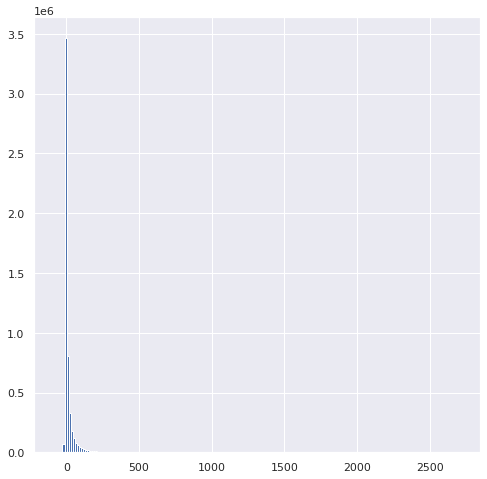

In [ ]:
sns.set(rc={'figure.figsize':(8,8)})
train_data['DEP_DELAY'].hist(bins=200)

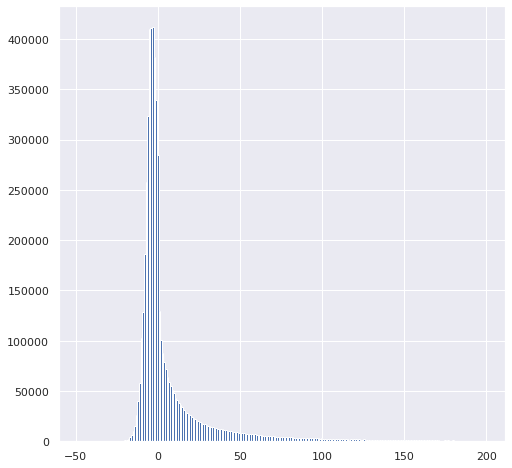

In [ ]:
sns.set(rc={'figure.figsize':(8,8)})
train_data['DEP_DELAY'][(train_data['DEP_DELAY'] < 200) & (train_data['DEP_DELAY'] > -50)].hist(bins=250)

A big number of flights departure before scheduled time. I assume that 'negative delays' not necessarily occur to reasons that are opposite to delays. That is, I assume that if a bad weather may lead to a delay, a good weather not necessarily lead to an early departure. Because of that I truncate negative values to focus on positive departures. 

In [ ]:
train_data['DEP_DELAY'][train_data['DEP_DELAY'] < 0] = 0
test_data['DEP_DELAY'][test_data['DEP_DELAY'] < 0] = 0

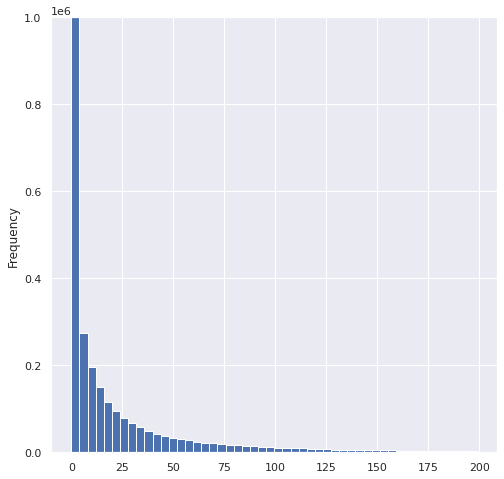

In [ ]:
sns.set(rc={'figure.figsize':(8,8)})
train_data['DEP_DELAY'][train_data['DEP_DELAY'] < 200 ].plot.hist(bins=50, ylim=(0,1000000))

In [ ]:
train_data.info()

In [ ]:
train_data.describe()

## Correlation between variables

In [ ]:
matrix_corr = train_data.corr()

In [ ]:
matrix_corr['DEP_DELAY']

DEP_DELAY              1.000000
DISTANCE               0.021118
CARRIER_DELAY          0.659201
WEATHER_DELAY          0.327188
NAS_DELAY              0.319582
SECURITY_DELAY         0.040123
LATE_AIRCRAFT_DELAY    0.615574
FL_DAYWEEK             0.004082
FL_MONTH              -0.023511
FL_DEP_HOUR            0.112841
FL_ARR_HOUR            0.095690
SIN_DEP_HOUR          -0.117533
COS_DEP_HOUR           0.032389
SIN_ARR_HOUR          -0.098494
COS_ARR_HOUR           0.099802
SIN_DAYWEEK           -0.010213
COS_DAYWEEK           -0.008259
SIN_MONTH              0.013804
COS_MONTH             -0.040395
LONGITUDE              0.016832
LATITUDE              -0.003749
TEMPERATURE            0.035103
DEW_POINT_TEMP         0.032413
REL_HUMIDITY          -0.001032
DIRECTION              0.006961
WIND_SPEED             0.057577
PRECIPITATION          0.039470
PRESSURE              -0.055477
MSLP                  -0.049473
VISIBILITY            -0.043538
WIND_GUST              0.042249
SKY_ALTI

The variables that correlate the most with the target are the five different types of delays. I don't have much information about how they are produced, but based on this information (https://aspm.faa.gov/aspmhelp/index/Types_of_Delay.html), I suppose that they represent different kinds of delays that occur prior to departure and that are known at the moment of prediction, because of that I keep them in the predictors. 

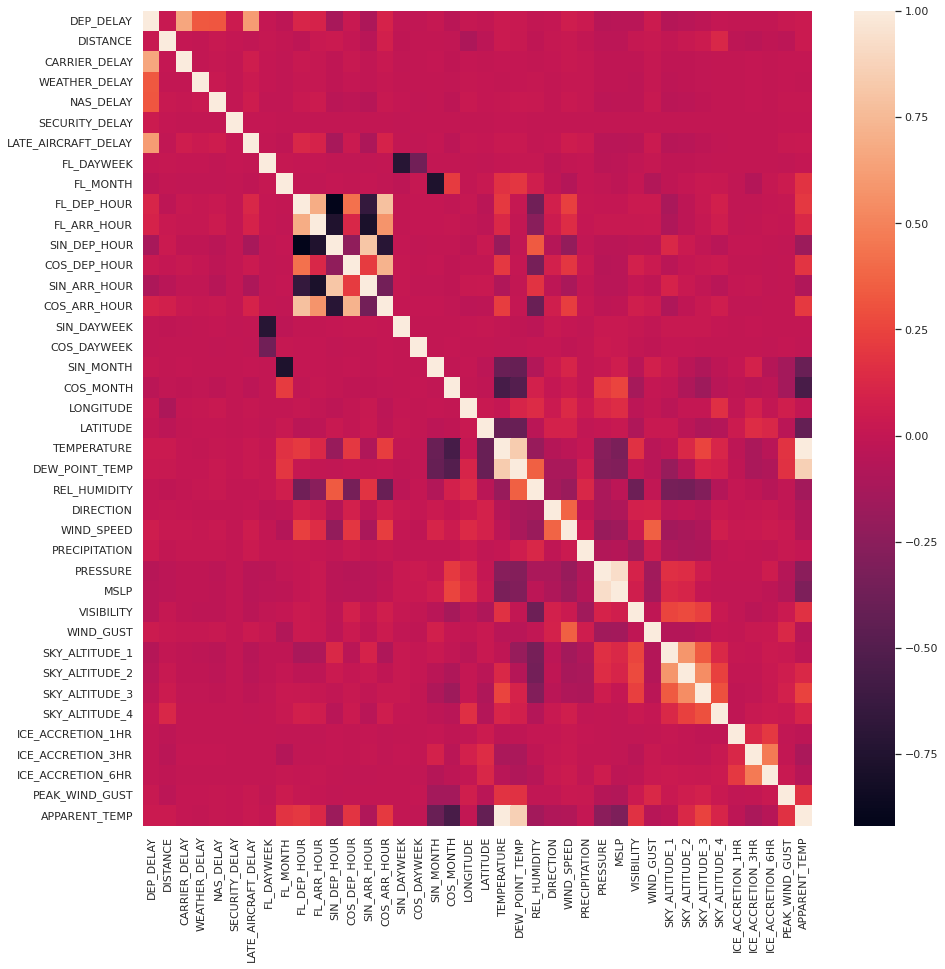

In [ ]:
sns.set(rc={'figure.figsize':(15,15)})
sns.heatmap(matrix_corr)

Unfortunatelly, the weather variables doesn't correlate that much with the target. There is some correlation between REL_HUMIDITY and TEMPERATURE with Departure and Arrival Times, as well as between temperature and Month. 

## Visualization

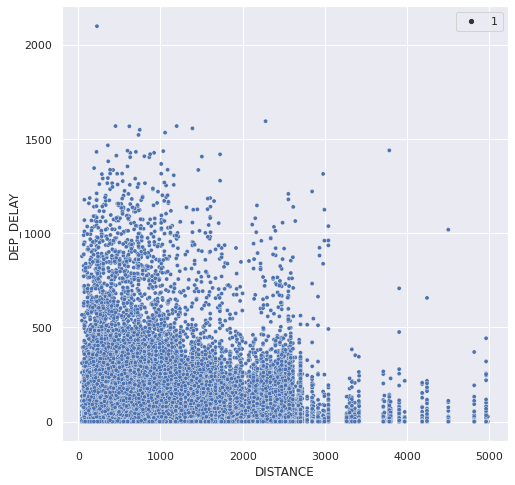

In [ ]:
sns.set(rc={'figure.figsize':(8,8)})
sns.scatterplot(x="DISTANCE", y="DEP_DELAY", data=train_data.sample(frac=0.2), size=1);

It is interesting to look at the scatterplot between distance and actual air time. It is naturally correlated but with some variation due to different airplane speeds. 

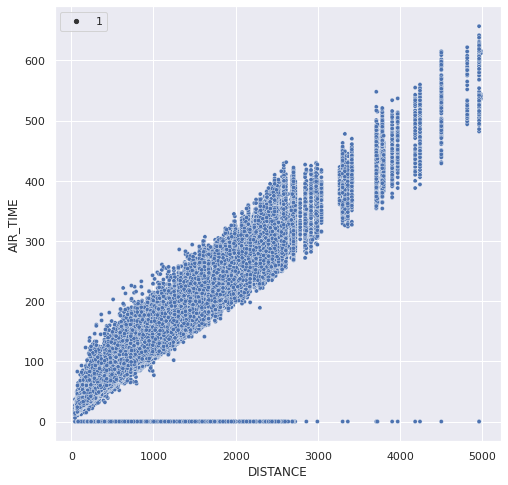

In [ ]:
sns.set(rc={'figure.figsize':(8,8)})
sns.scatterplot(x="DISTANCE", y="AIR_TIME", data=train_data.sample(frac=0.2), size=1);

It is noticeable that there are airports where smaller delays happen. 

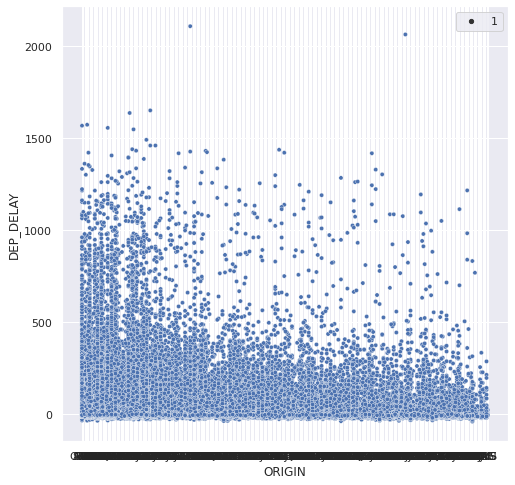

In [ ]:
sns.set(rc={'figure.figsize':(8,8)})
sns.scatterplot(x="ORIGIN", y="DEP_DELAY", data=train_data.sample(frac=0.2), size=1);

In [ ]:
train_data.groupby('ORIGIN')['DEP_DELAY'].mean().sort_values(ascending=False)[0:10]

ORIGIN
OTH    42.214925
SWF    37.333333
HYA    29.276316
EGE    25.937240
SLN    24.005682
CMX    23.914855
OAJ    23.492754
JMS    23.466667
MEI    23.383142
ACK    23.033822
Name: DEP_DELAY, dtype: float64

In [ ]:
train_data.groupby('ORIGIN')['DEP_DELAY'].mean().sort_values(ascending=True)[0:10]

ORIGIN
SUN   -7.000000
HVN   -5.000000
SHD   -3.000000
LWS   -1.557962
ATW   -1.454545
PIH   -1.420464
EKO   -1.299689
EAR   -1.010799
CPR   -0.036525
BFF    0.020619
Name: DEP_DELAY, dtype: float64

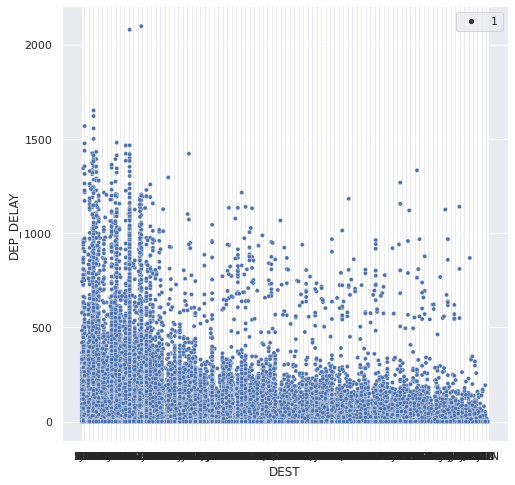

In [ ]:
sns.set(rc={'figure.figsize':(8,8)})
sns.scatterplot(x="DEST", y="DEP_DELAY", data=train_data.sample(frac=0.2), size=1);

In [ ]:
train_data.groupby('DEST')['DEP_DELAY'].mean().sort_values(ascending=False)[0:10]

DEST
OGS    38.729167
PBG    33.300236
OTH    28.524934
CKB    27.236453
CMX    24.185629
ASE    22.684237
MQT    22.353668
MMH    22.151057
BQN    21.951785
EWR    21.876961
Name: DEP_DELAY, dtype: float64

In [ ]:
train_data.groupby('DEST')['DEP_DELAY'].mean().sort_values(ascending=True)[0:10]

DEST
HVN   -3.535714
WYS   -1.194444
CPR   -0.476378
BTM   -0.020802
CDC    0.530581
LWS    0.901796
EKO    1.665116
PIH    1.802236
TWF    1.981114
DRT    2.045064
Name: DEP_DELAY, dtype: float64

Next I have scatterplots of the five delay variables against departure delay. All of them have two main 'trends'. This tells that a departure delay is possibly explained by one of the five delay types. In these case the values of this type and of dep_delay will be similar, while for the remaining ones it will be some value most closer to zero. 

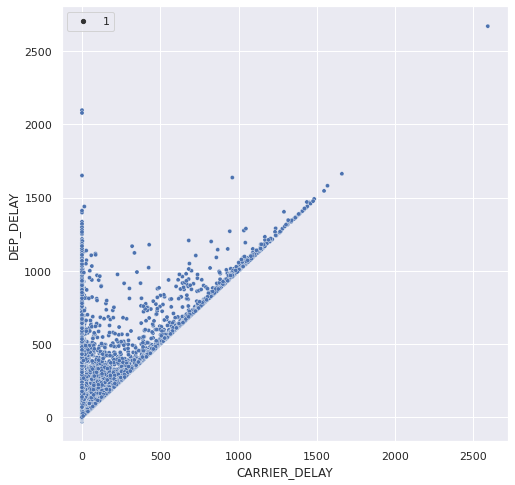

In [ ]:
sns.set(rc={'figure.figsize':(8,8)})
sns.scatterplot(x="CARRIER_DELAY", y="DEP_DELAY", data=train_data.sample(frac=0.2), size=1);

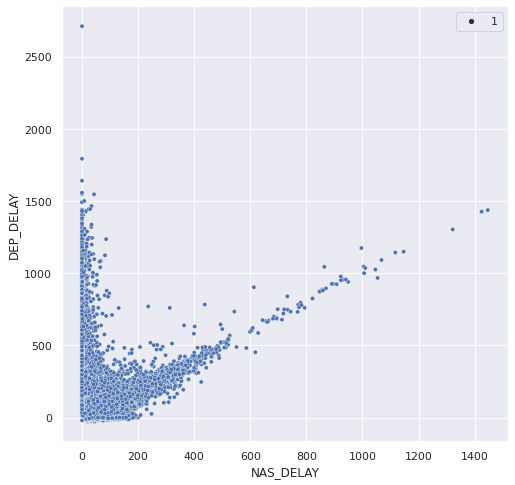

In [ ]:
sns.set(rc={'figure.figsize':(8,8)})
sns.scatterplot(x="NAS_DELAY", y="DEP_DELAY", data=train_data.sample(frac=0.2), size=1);

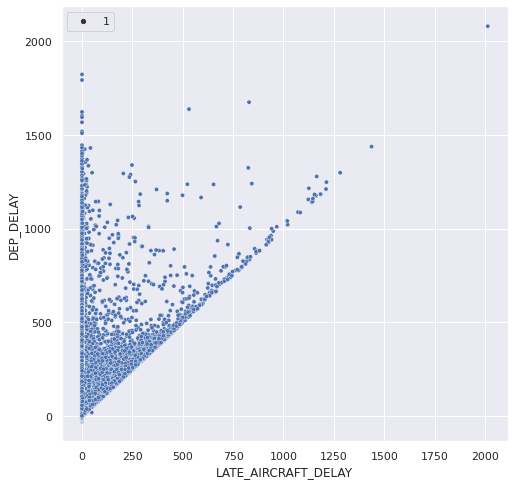

In [ ]:
sns.set(rc={'figure.figsize':(8,8)})
sns.scatterplot(x="LATE_AIRCRAFT_DELAY", y="DEP_DELAY", data=train_data.sample(frac=0.2), size=1);

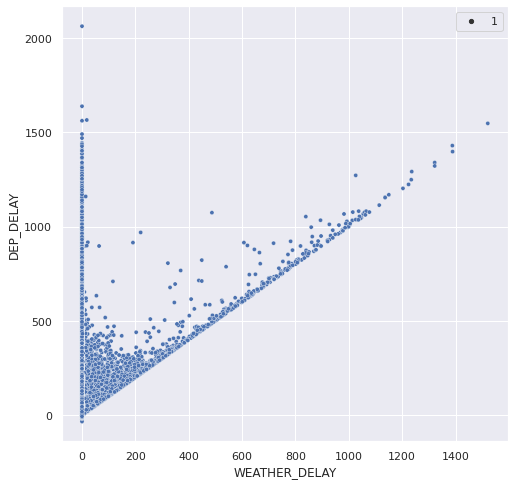

In [ ]:
sns.set(rc={'figure.figsize':(8,8)})
sns.scatterplot(x="WEATHER_DELAY", y="DEP_DELAY", data=train_data.sample(frac=0.2), size=1);

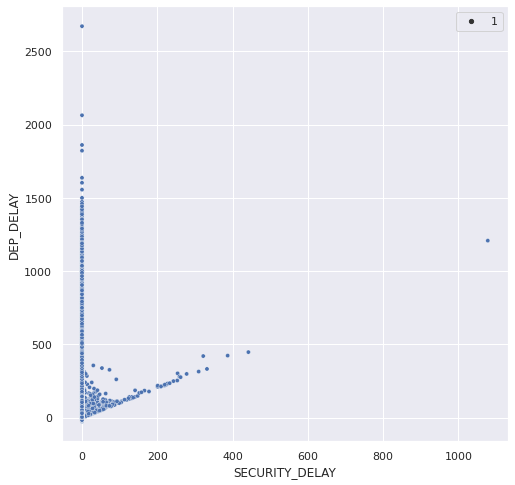

In [ ]:
sns.set(rc={'figure.figsize':(8,8)})
sns.scatterplot(x="SECURITY_DELAY", y="DEP_DELAY", data=train_data.sample(frac=0.2), size=1);

Next we look at the different average delays according to different airline companies. Apparently Carrier Delay means delay that can be attributed to the airline. It would be interesting to know if the airlines with highest general delay are the same with higher carrier delay. As the plots show, the distribution is similar, except by DL and OO, which proportionaly have higher Carrier Delays. 

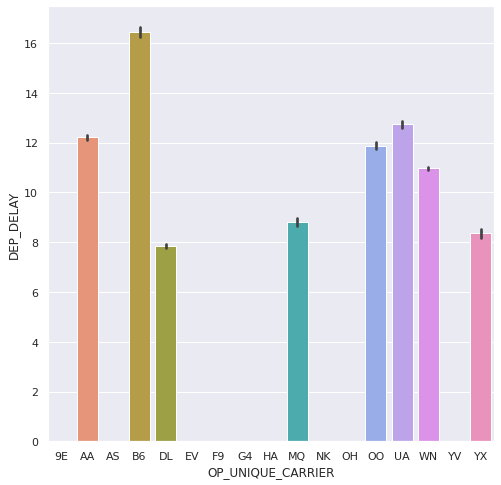

In [ ]:
sns.set(rc={'figure.figsize':(8,8)})
sns.barplot(x="OP_UNIQUE_CARRIER", y="DEP_DELAY",  data=train_data)

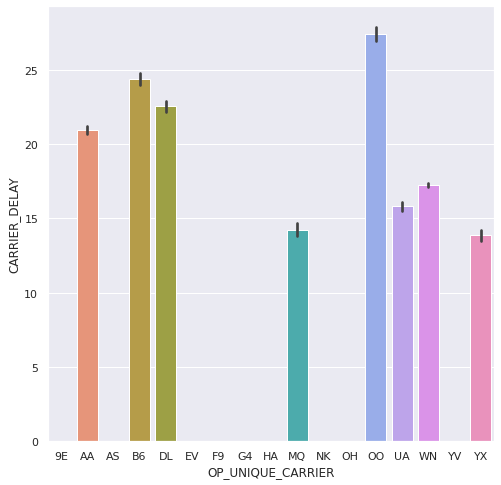

In [ ]:
sns.set(rc={'figure.figsize':(8,8)})
sns.barplot(x="OP_UNIQUE_CARRIER", y="CARRIER_DELAY",  data=train_data)

Clearly, the delay varies with the hour. Flights in the early morning have the lowest delays while flights at the early evening have bigger delays, probably because airports are busier. Similar thing happens to the scheduler arrival time. 

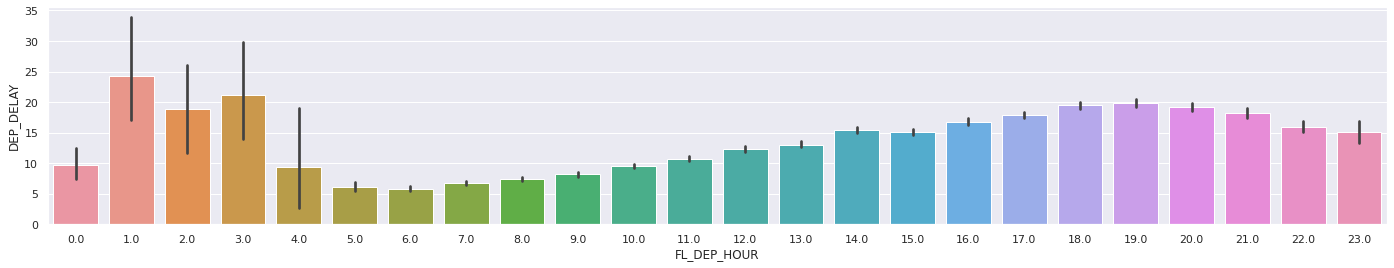

In [ ]:
sns.barplot(x="FL_DEP_HOUR", y="DEP_DELAY",  data=train_data)

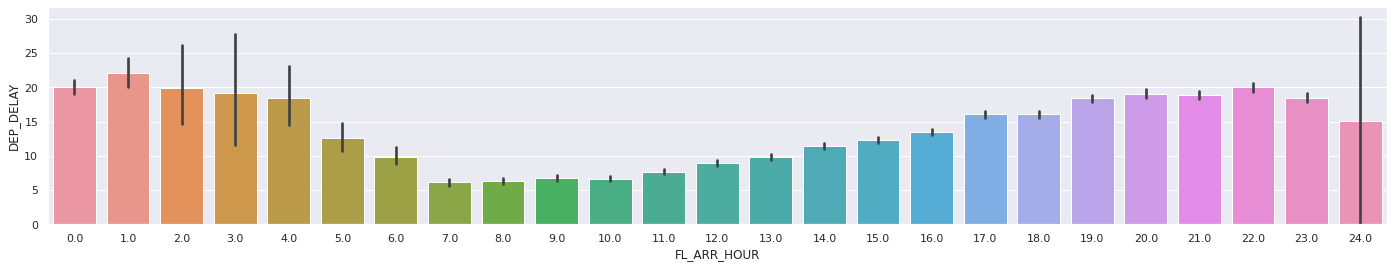

In [ ]:
sns.barplot(x="FL_ARR_HOUR", y="DEP_DELAY",  data=train_data)

There is not much correlation between the departure delay and the days of the week. 

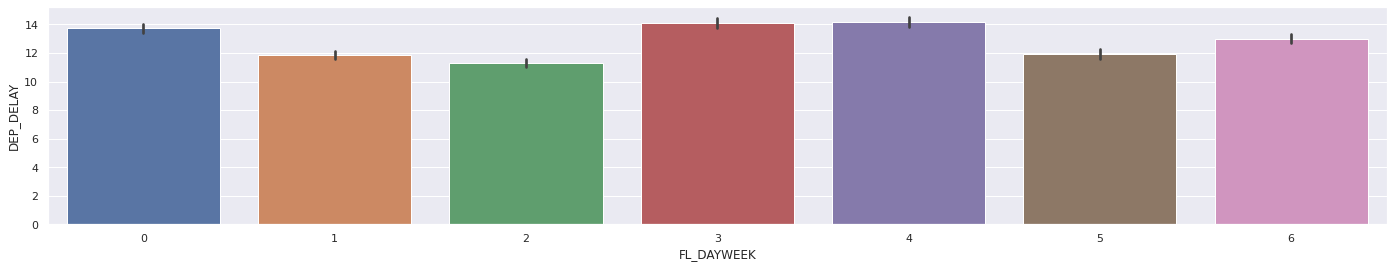

In [ ]:
sns.barplot(x="FL_DAYWEEK", y="DEP_DELAY",  data=train_data)

Bigger delays happen on the summer (in the north hemisphere), probably due to airports being busier. 

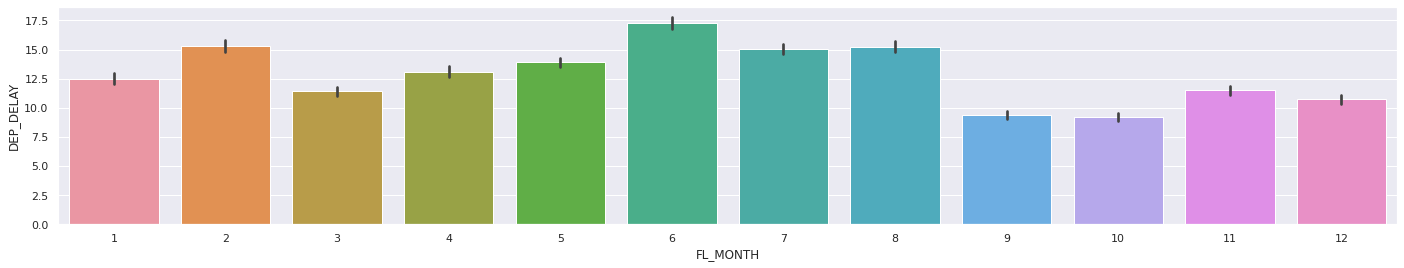

In [ ]:
sns.barplot(x="FL_MONTH", y="DEP_DELAY",  data=train_data)

In [ ]:
train_data.columns

Index(['FL_DATE', 'OP_UNIQUE_CARRIER', 'ORIGIN', 'DEST', 'DEP_DELAY',
       'DISTANCE', 'CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY',
       'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY', 'FL_DAYWEEK', 'FL_MONTH',
       'FL_DEP_HOUR', 'FL_ARR_HOUR', 'SIN_DEP_HOUR', 'COS_DEP_HOUR',
       'SIN_ARR_HOUR', 'COS_ARR_HOUR', 'SIN_DAYWEEK', 'COS_DAYWEEK',
       'SIN_MONTH', 'COS_MONTH', 'LONGITUDE', 'LATITUDE', 'TEMPERATURE',
       'DEW_POINT_TEMP', 'REL_HUMIDITY', 'DIRECTION', 'WIND_SPEED',
       'PRECIPITATION', 'PRESSURE', 'MSLP', 'VISIBILITY', 'WIND_GUST',
       'SKY_COVERAGE_1', 'SKY_COVERAGE_2', 'SKY_COVERAGE_3', 'SKY_COVERAGE_4',
       'SKY_ALTITUDE_1', 'SKY_ALTITUDE_2', 'SKY_ALTITUDE_3', 'SKY_ALTITUDE_4',
       'ICE_ACCRETION_1HR', 'ICE_ACCRETION_3HR', 'ICE_ACCRETION_6HR',
       'PEAK_WIND_GUST', 'APPARENT_TEMP'],
      dtype='object')

It is not surprising that the location of airports, measure by its latitude and longitude has no relation with the delay. 

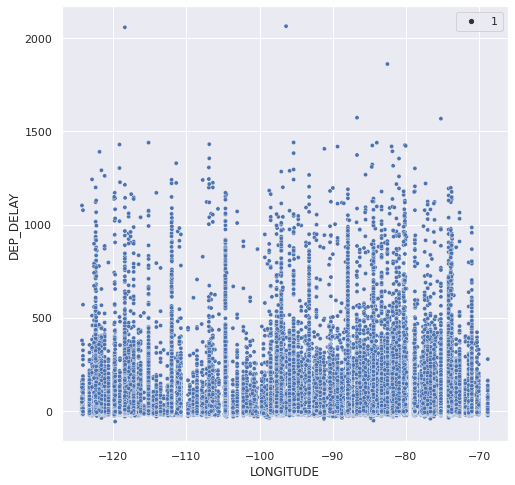

In [ ]:
sns.set(rc={'figure.figsize':(8,8)})
sns.scatterplot(x="LONGITUDE", y="DEP_DELAY", data=train_data.sample(frac=0.2), size=1);

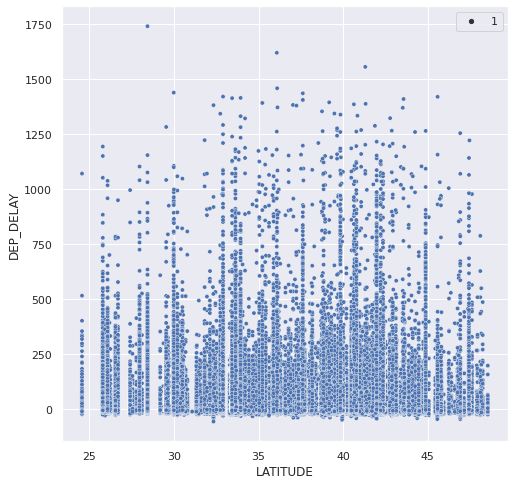

In [ ]:
sns.set(rc={'figure.figsize':(8,8)})
sns.scatterplot(x="LATITUDE", y="DEP_DELAY", data=train_data.sample(frac=0.2), size=1);

The scatterplots of precipitation, visibility, and wind speed show strange results. With very low relation with the delay or even some relation opposite to what is expected. There might be some problem with this data

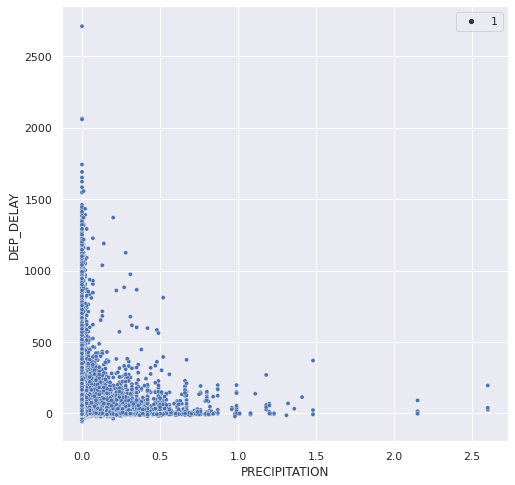

In [ ]:
sns.set(rc={'figure.figsize':(8,8)})
sns.scatterplot(x="PRECIPITATION", y="DEP_DELAY", data=train_data.sample(frac=0.2), size=1);

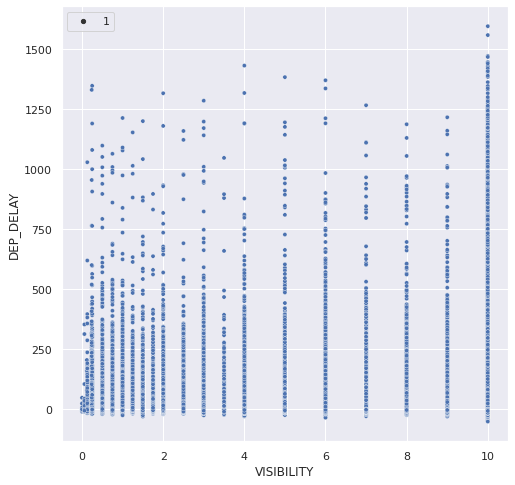

In [ ]:
sns.set(rc={'figure.figsize':(8,8)})
sns.scatterplot(x="VISIBILITY", y="DEP_DELAY", data=train_data.sample(frac=0.2), size=1);

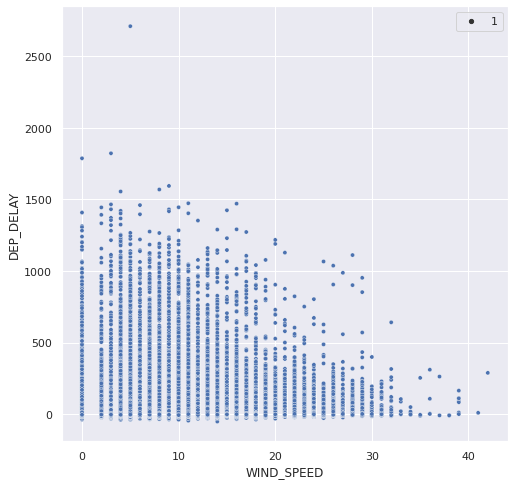

In [ ]:
sns.set(rc={'figure.figsize':(8,8)})
sns.scatterplot(x="WIND_SPEED", y="DEP_DELAY", data=train_data.sample(frac=0.2), size=1);

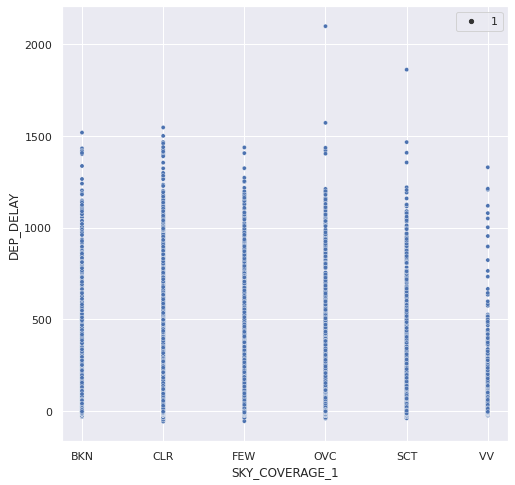

In [ ]:
sns.set(rc={'figure.figsize':(8,8)})
sns.scatterplot(x="SKY_COVERAGE_1", y="DEP_DELAY", data=train_data.sample(frac=0.2), size=1);

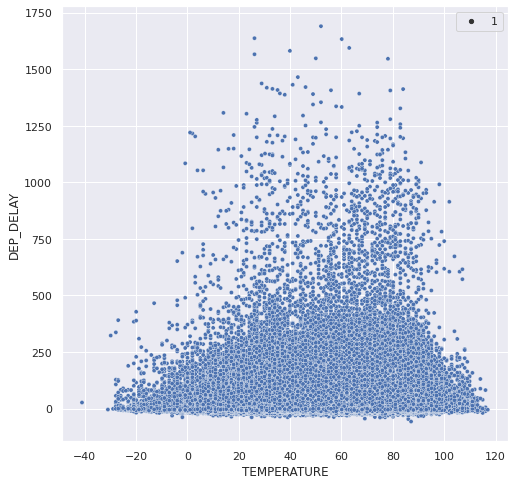

In [ ]:
sns.set(rc={'figure.figsize':(8,8)})
sns.scatterplot(x="TEMPERATURE", y="DEP_DELAY", data=train_data.sample(frac=0.2), size=1);

# Training

Usually it would be necessary to use one-hot encoding on categorical variables, like origin and destination airports and airline. However this would generate hundreds of dummy variables, which would break the RAM capacity of Google Colab. To deal with that I use h2o, whose algorithms handle categorical variables without requiring one-hot encoding.  

In [ ]:
h2o.init(port=54322)

Checking whether there is an H2O instance running at http://localhost:54322 . connected.


H2O_cluster_uptime:,39 mins 09 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.36.0.3
H2O_cluster_version_age:,27 days
H2O_cluster_name:,H2O_from_python_unknownUser_zags79
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.048 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


In [ ]:
training_columns = list(train_data.columns.drop('DEP_DELAY'))
response_column = 'DEP_DELAY'

In [ ]:
train_data = train_data.sample(frac=0.25)
test_data = test_data.sample(frac=0.5)

In [ ]:
train_frame = h2o.H2OFrame(train_data)
test_frame = h2o.H2OFrame(test_data)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [ ]:
 model = H2ODeepLearningEstimator(distribution="gaussian",
                               hidden=[10,10],
                               epochs=5,
                               train_samples_per_iteration=-1,
                               reproducible=True,
                               activation="rectifier",
                               single_node_mode=False,
                               balance_classes=False,
                               force_load_balance=False,
                               seed=23123,
                               score_training_samples=0,
                               score_validation_samples=0,
                               stopping_rounds=0)

In [ ]:
model.train(x=training_columns, y=response_column, training_frame=train_frame, validation_frame=test_frame)

deeplearning Model Build progress: |█████████████████████████████████████████████| (done) 100%
Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_model_python_1647381618527_1


Status of Neuron Layers: predicting DEP_DELAY, regression, gaussian distribution, Quadratic loss, 6,881 weights/biases, 99.2 KB, 6,663,380 training samples, mini-batch size 1


,,layer,units,type,dropout,l1,l2,mean_rate,rate_rms,momentum,mean_weight,weight_rms,mean_bias,bias_rms
0,,1,675,Input,0.0,,,,,,,,,
1,,2,10,Rectifier,0.0,0.0,0.0,0.019526,0.113491,0.0,0.000197,0.099736,0.413232,0.526327
2,,3,10,Rectifier,0.0,0.0,0.0,0.004827,0.007463,0.0,-0.062117,0.424232,0.8946,0.195302
3,,4,1,Linear,,0.0,0.0,0.000493,0.000428,0.0,0.04778,0.274558,0.343029,0.0




ModelMetricsRegression: deeplearning
** Reported on train data. **

MSE: 90.17250811183567
RMSE: 9.495920603703238
MAE: 5.398049692749421
RMSLE: NaN
Mean Residual Deviance: 90.17250811183567

ModelMetricsRegression: deeplearning
** Reported on validation data. **

MSE: 101.700399647034
RMSE: 10.08466160300057
MAE: 5.669396148288296
RMSLE: NaN
Mean Residual Deviance: 101.700399647034

Scoring History: 


,,timestamp,duration,training_speed,epochs,iterations,samples,training_rmse,training_deviance,training_mae,training_r2,validation_rmse,validation_deviance,validation_mae,validation_r2
0,,2022-03-15 22:42:13,0.000 sec,None,0.0,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,,2022-03-15 22:42:52,1 min 20.656 sec,33928 obs/sec,1.0,1,1332676.0,9.767672,95.407421,5.374859,0.955844,10.532051,110.924101,5.690337,0.959545
2,,2022-03-15 22:43:52,2 min 18.238 sec,34032 obs/sec,2.0,2,2665352.0,9.495921,90.172508,5.398050,0.958267,10.084662,101.700400,5.669396,0.962909
3,,2022-03-15 22:44:47,3 min 13.322 sec,34797 obs/sec,3.0,3,3998028.0,9.573147,91.645148,5.206460,0.957586,10.191262,103.861814,5.496041,0.962121
4,,2022-03-15 22:45:46,4 min 10.539 sec,34436 obs/sec,4.0,4,5330704.0,9.512781,90.493001,5.411376,0.958119,10.189827,103.832568,5.606400,0.962132
5,,2022-03-15 22:46:46,5 min 10.663 sec,33702 obs/sec,5.0,5,6663380.0,9.478753,89.846752,5.175066,0.958418,10.138646,102.792140,5.436484,0.962511
6,,2022-03-15 22:47:03,5 min 28.077 sec,33700 obs/sec,5.0,5,6663380.0,9.495921,90.172508,5.398050,0.958267,10.084662,101.700400,5.669396,0.962909



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,NAS_DELAY,1.000000,1.000000,0.021006
1,LATE_AIRCRAFT_DELAY,0.832955,0.832955,0.017497
2,CARRIER_DELAY,0.722175,0.722175,0.015170
3,WEATHER_DELAY,0.415756,0.415756,0.008733
4,DEST.SFO,0.345584,0.345584,0.007259
5,DEST.EWR,0.296277,0.296277,0.006224
6,OP_UNIQUE_CARRIER.WN,0.272028,0.272028,0.005714
7,DEST.BOS,0.252303,0.252303,0.005300
8,DEST.LGA,0.217072,0.217072,0.004560
9,OP_UNIQUE_CARRIER.OO,0.206775,0.206775,0.004344



See the whole table with table.as_data_frame()


In [ ]:
performance = model.model_performance(test_data=test_frame)
print(performance)


ModelMetricsRegression: deeplearning
** Reported on test data. **

MSE: 101.700399647034
RMSE: 10.08466160300057
MAE: 5.669396148288296
RMSLE: NaN
Mean Residual Deviance: 101.700399647034



In [ ]:
print(model.r2(valid=False))
print(model.r2(valid=True))

0.9582672396917821
0.9629093927773504


As it can be seen, the model heavily relies on the delay variables, later the origin and destination airports. Overall, the resulting performance is quite good. 